# Classification Problems

First I'll download the MNIST dataset.
The MNIST dataset is a set of 70.000 small images of digits handwritten by high school students and employees of the US Census Bureau.

Each image is labeled with the digit it represents.

In [103]:
import warnings
warnings.filterwarnings('ignore')

# Download the MNIST dataset with the functions provided by Scikit Learn.
from sklearn.datasets import fetch_mldata
mnist_data = fetch_mldata('MNIST original')

In [69]:
mnist_data # Show the mnist_data

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

Information about each key of the dataset's map:
  * 'DESCR': Description of the dataset
  * 'data': Contains an array with one row per instance and one column per feature.
  * 'target': Contains an array with the labels


In [70]:
data, labels = mnist_data['data'], mnist_data['target'] # separate the data and the labels

In [71]:
data.shape # the data consists of 70.000 images and 784 features (in this case each feature is a pixel)

(70000, 784)

In [72]:
labels.shape # there are 70.000 labels (one for each image, so for a given number n: data[n] represents label[n])

(70000,)

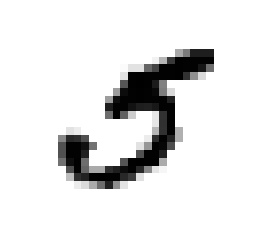

In [73]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = data[36000] # choose a random image from the dataset
some_digit_image = some_digit.reshape(28, 28) # reshape it to a 28x28 image.

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [74]:
labels[36000] # let's check the label for that image!

5.0

Now we need to create a test set and a training set for each array. The MNIST dataset is already separated, the first 60.000 images are the training set and the last 10.000 images are the train set.

Then we need to shuffle the training set, this will guarantee that all cross-validation folds will be similar.
Some algorithms are sensitive to the order of the training instances and they perform poorly if they get many similiar instances in a row. Shuffling the dataset ensures this won't happen. But shuffling is not a silver bullet. In some contexts you can't shuffle the dataset because of the nature of the dataset (times series data, like stock market prices and weather related data).

In [75]:
data_train, data_test, labels_train, labels_test = data[:60000], data[60000:], labels[:60000], labels[60000:]

In [85]:
# shuffling
import numpy as np

shuffle_index = np.random.permutation(60000) # generate a random permutation of the indices
data_train, labels_train = data_train[shuffle_index], labels_train[shuffle_index] # permutate the elements

## Training a Binary Classifier

Let's train a binary classifier that detects if a given image is a 5 or not.
For that task we are going to use a Stochastic Gradient Descent (SGD) classifier using the SGDClassifer class from Scikit-Learn.
This classifier can handle a lot of data efficiently. It's also suitable for online learning.

In [86]:
labels_train_5 = (labels_train == 5) # gets an array of booleans telling if each element is equal to five
labels_test_5 = (labels_test == 5)

In [106]:
from sklearn.linear_model import SGDClassifier

RANDOM_STATE = 42 # fix the state to get reproducible results

sgd_classifier = SGDClassifier(random_state = RANDOM_STATE)
sgd_classifier.fit(data_train, labels_train_5) # trains the model

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [89]:
sgd_classifier.predict([some_digit]) # it works!

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

#### K-Fold Cross-Validation
In k-fold cross validation the original training set is partitioned into k subsets (named folds) of size $ m/k $ (for simplicity, assume that $ m/k $ is an integer). For each fold, the algorithm is trained on the union of the other folds and then the error of its output is estimated using the fold. Finally, the average of all of these errors is the estimate of the true error. 
K-Fold cross validation is often used for model selection and parameter tuning. Once the best parameter is chosen, the algorithm is retrained using this parameter on the entire training set.

The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [105]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(data_train, labels_train_5):
    clone_classifier = clone(sgd_classifier) # clone the classifier
    data_train_folds = data_train[train_index]
    labels_train_folds = labels_train_5[train_index]
    data_test_fold = data_train[test_index]
    labels_test_fold = labels_train_5[test_index]
    
    clone_classifier.fit(data_train_folds, labels_train_folds) # train the cloned clf.
    label_predict = clone_classifier.predict(data_test_fold)
    n_correct = sum(label_predict == labels_test_fold)
    print(n_correct / len(label_predict))

0.938
0.9637
0.9576


In [104]:
# Now using the tools from sklearn, it should be the same as doing it manually
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, data_train, labels_train_5, cv = 3, scoring = 'accuracy')

array([0.938 , 0.9637, 0.9576])